## When to declare victory in an election?

**Objective**: The goal of this project is to model when Candidate A can confidently declare victory in an election based on real-time vote tallies, using Bayesian statistics with a Gamma prior. The model estimates the probability that Candidate A will win, given a dynamic tally of votes, and determines the point at which Candidate A can announce victory with 95% confidence.

Key Approach:
- Simulate votes using a true proportion for Candidate A.
- Use a Gamma prior to model the uncertainty in the vote distribution.
- Update the posterior as votes are counted.
- Compute the credible interval for the vote share and check when the lower bound exceeds 50%, indicating a majority.
- Announce victory once Candidate A's win is 95% certain.

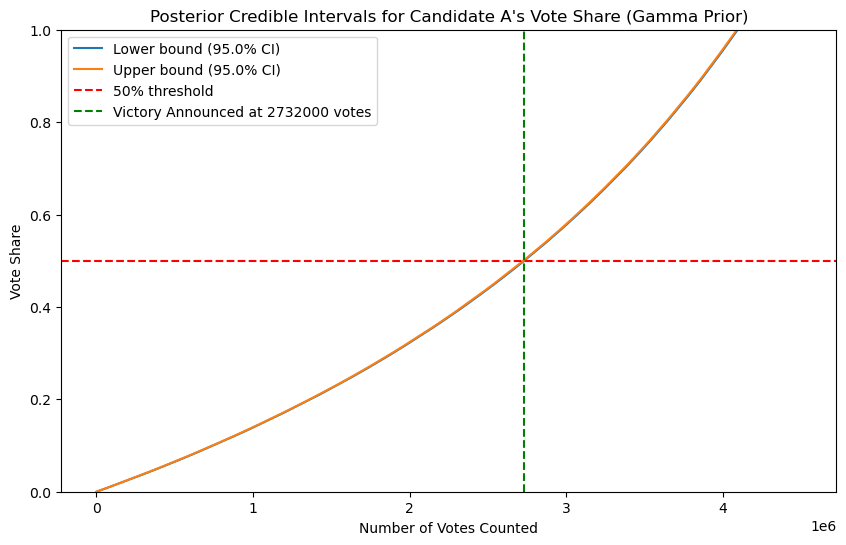

Announce after 2732000 votes with 95.0% confidence


In [54]:
# Let's implement the working version and add the corrections for vote share normalization

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Set up parameters for simulation
total_voters = 4500000
true_prob_A = 0.55  # True proportion of votes for Candidate A
confidence_level = 0.95  # You can set this to 0.5 to see the difference

# Prior distribution (Gamma prior for real-world uncertainty)
shape_A_prior = 2  # Shape parameter for Gamma distribution for Candidate A
rate_A_prior = 5   # Rate parameter for Gamma distribution for Candidate A

shape_B_prior = 2  # Shape parameter for Gamma distribution for Candidate B
rate_B_prior = 5   # Rate parameter for Gamma distribution for Candidate B

# Simulate the voting process
votes_A = np.random.binomial(1, true_prob_A, total_voters)

# Keep track of cumulative counts of votes for A and B
cumulative_votes_A = np.cumsum(votes_A)
cumulative_votes_B = np.arange(1, total_voters + 1) - cumulative_votes_A

# Function to compute the posterior distribution using Gamma priors
def compute_gamma_posterior(shape_A_prior, rate_A_prior, shape_B_prior, rate_B_prior, votes_A, votes_B):
    shape_A_post = shape_A_prior + votes_A
    rate_A_post = rate_A_prior + total_voters - votes_A
    shape_B_post = shape_B_prior + votes_B
    rate_B_post = rate_B_prior + total_voters - votes_B
    return shape_A_post, rate_A_post, shape_B_post, rate_B_post

# Function to compute the credible interval for a given confidence level using Gamma
def compute_gamma_credible_interval(shape_post, rate_post, confidence_level):
    lower_bound = gamma.ppf((1 - confidence_level) / 2, shape_post, scale=1 / rate_post)
    upper_bound = gamma.ppf(1 - (1 - confidence_level) / 2, shape_post, scale=1 / rate_post)
    return lower_bound, upper_bound

# Adjust simulation to check victory at every 1000 votes instead of each individual vote
step_size = 1000

# Variables to store the decision point
announce_round = None
lower_bounds = []
upper_bounds = []

# Simulate vote counting and Bayesian updates every step_size votes
for i in range(step_size, total_voters + 1, step_size):
    votes_A_so_far = cumulative_votes_A[i - 1]
    votes_B_so_far = cumulative_votes_B[i - 1]
    
    # Update posterior using Gamma prior
    shape_A_post, rate_A_post, shape_B_post, rate_B_post = compute_gamma_posterior(
        shape_A_prior, rate_A_prior, shape_B_prior, rate_B_prior, votes_A_so_far, votes_B_so_far
    )
    
    # Compute credible interval using Gamma
    lower_bound, upper_bound = compute_gamma_credible_interval(shape_A_post, rate_A_post, confidence_level)
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)
    
    # Check if Candidate A can announce victory (if the lower bound exceeds 0.5)
    if lower_bound > 0.5 and announce_round is None:
        announce_round = i

# Normalize the cumulative votes for Candidate A to represent vote share
vote_share_A = cumulative_votes_A[:total_voters // step_size] / np.arange(step_size, total_voters + 1, step_size)

# Plot the credible intervals and the normalized vote share
x = np.arange(step_size, total_voters + 1, step_size)

plt.figure(figsize=(10, 6))
plt.plot(x, lower_bounds, label=f'Lower bound ({confidence_level*100}% CI)')
plt.plot(x, upper_bounds, label=f'Upper bound ({confidence_level*100}% CI)')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% threshold')
if announce_round:
    plt.axvline(x=announce_round, color='g', linestyle='--', label=f'Victory Announced at {announce_round} votes')
plt.title(f'Posterior Credible Intervals for Candidate A\'s Vote Share (Gamma Prior)')
plt.xlabel('Number of Votes Counted')
plt.ylabel('Vote Share')
plt.ylim([0, 1])  # Ensure vote share maxes out at 1
plt.legend()
plt.show()

print(f"Announce after {announce_round} votes with {confidence_level*100}% confidence")
